<a href="https://colab.research.google.com/github/Higgins2718/AirstripClassifier/blob/master/AirstripClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from keras import models
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Load the pretrained InceptionV3 model for transfer learning

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

x = layers.Flatten()(pre_trained_model.output)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dropout(0.2)(x)

x = layers.Dense(1, activation='sigmoid')(x)


model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [5]:
import pandas as pd
from google.colab import drive

# Load the airstrips dataset from Google Drive

drive.mount('/content/drive')

!ln -s "/content/drive/My Drive/satellite_airstrips/train/"/mydrive

!mount --bind /content/drive/My\ Drive /content/mounted_drive/
%cd /content/mounted_drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link './mydrive': File exists
/content/mounted_drive


In [0]:
# Create training and testing datasets

import tensorflow as tf
directory = '/content/drive/My Drive/satellite_airstrips/'
from glob import glob
from sklearn.model_selection import train_test_split

strips = glob("/content/mounted_drive/satellite_airstrips/train/landing_strips_4/*.jpg")
not_strips = glob("/content/mounted_drive/satellite_airstrips/train/not_landing_strips_4/*.jpg")

strips_train, strips_test = train_test_split(strips, test_size=0.1)
not_strips_train, not_strips_test = train_test_split(not_strips, test_size=0.1)

TRAIN_DIR = 'train'
TEST_DIR = 'test'

!mkdir test
!mkdir train

!mkdir test/strips
files = ' '.join(strips_test)
!mv -t test/strips $files

!mkdir test/not_strips
files = ' '.join(not_strips_test)
!mv -t test/not_strips $files



!mkdir train/strips
files = ' '.join(strips_train)
!mv -t train/strips $files

!mkdir train/not_strips
files = ' '.join(not_strips_train)
!mv -t train/not_strips $files

In [14]:
# Load images from the training and testing datasets
# Add some data augmentation to the images so the model doesn't overfit

TRAIN_DIR = '/content/mounted_drive/train'
TEST_DIR = '/content/mounted_drive/test'

train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                  horizontal_flip = True,
                                  rotation_range = 40)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

validation_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                        batch_size = 20,
                                                        class_mode = 'binary',
                                                        target_size = (150, 150), shuffle=False) 

Found 1485 images belonging to 2 classes.
Found 166 images belonging to 2 classes.


In [0]:
# Stop training once accuracy hits 99.9%

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.959):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [0]:
# Add variables for the length of the train and validation data 
ntrain = 1485
nval = 166

# We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32

In [17]:
# Train the model

callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = ntrain // batch_size,
            epochs = 20,
            validation_steps = nval // batch_size,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


46/46 - 220s - loss: 0.8383 - acc: 0.7591 - val_loss: 1.6375 - val_acc: 0.6000
Epoch 2/20
46/46 - 220s - loss: 0.3597 - acc: 0.8751 - val_loss: 1.7541 - val_acc: 0.7000
Epoch 3/20
46/46 - 221s - loss: 0.2031 - acc: 0.9215 - val_loss: 4.0426 - val_acc: 0.5800
Epoch 4/20
46/46 - 216s - loss: 0.2992 - acc: 0.9116 - val_loss: 4.3762 - val_acc: 0.4300
Epoch 5/20
46/46 - 218s - loss: 0.1734 - acc: 0.9293 - val_loss: 1.4525 - val_acc: 0.8500
Epoch 6/20
46/46 - 220s - loss: 0.2163 - acc: 0.9293 - val_loss: 0.8861 - val_acc: 0.8800
Epoch 7/20
46/46 - 215s - loss: 0.1807 - acc: 0.9525 - val_loss: 0.9009 - val_acc: 0.9300
Epoch 8/20
46/46 - 221s - loss: 0.2179 - acc: 0.9326 - val_loss: 0.4791 - val_acc: 0.9100
Epoch 9/20
46/46 - 229s - loss: 0.1517 - acc: 0.9467 - val_loss: 0.5682 - val_acc: 0.9600
Epoch 10/20
46/46 - 220s - loss: 0.1404 - acc: 0.9558 - val_loss: 0.3570 - val_acc: 0.9200
Epoch 11/20

Reached 99.9% accuracy so cancelling training!
46/46 - 223s - loss: 0.1098 - acc: 0.9691 - val_lo

In [18]:
# Check the model's accuracy on the test dataset

test_loss, test_acc = model.evaluate_generator(validation_generator)
print('test acc:', test_acc)
print('test loss:', test_loss)

test acc: 0.9216867685317993
test loss: 0.6053807735443115


In [0]:
# Save the model

model.save_weights('airstrip_classifier_weights.h5')
model.save('airstrip_classifier.h5')

In [19]:
# Get a list of all misclassified images in our test dataset
predicted = model.predict(validation_generator)
indices = [i for i,v in enumerate(predicted) if round(predicted[i][0])!=validation_generator.classes[i]]
misclassified_imgs = []
for index, file in enumerate(validation_generator.filenames):
  if index in indices:
    print(file)
    misclassified_imgs.append(file)

not_strips/36.357900596421864-116.59087616284064.jpg
not_strips/38.93265314899398-99.2073882340789.jpg
not_strips/42.1122281328539-90.40852258117864.jpg
not_strips/42.81556639125244-90.19088212023023.jpg
not_strips/43.013831842124134-83.32170289828017.jpg
not_strips/44.74780260391893-87.70133392734365.jpg
not_strips/48.05621824809539-73.16933115096072.jpg
strips/0A2DC496-F49E-426F-9709-E9C2AFE5345E.jpg
strips/3CD1E697-7E62-40B0-8944-5B4D06183F75.jpg
strips/5DFA7A4A-4449-4D28-AD94-3656445CCC66.jpg
strips/AB9D6CBA-1B2A-4794-B959-46EA5D13BD38.jpg
strips/AD75D47E-FD77-42D9-B2CE-CCECFBB4F12B.jpg
strips/C0E1D327-86A0-4D6A-BC65-20B6816BFFDE.jpg


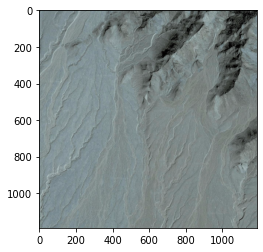

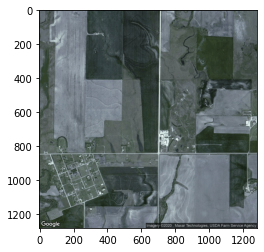

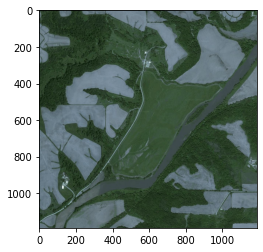

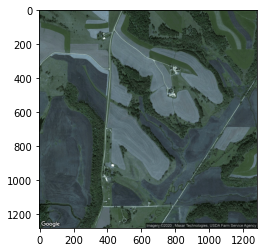

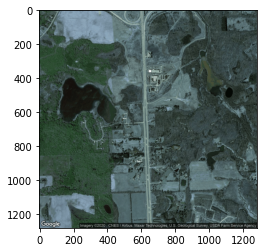

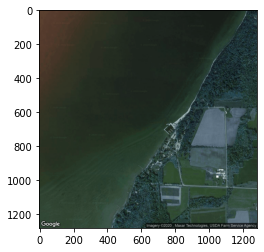

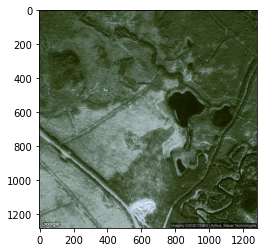

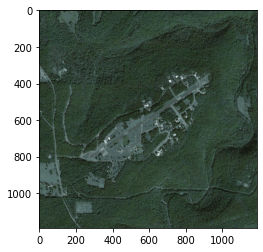

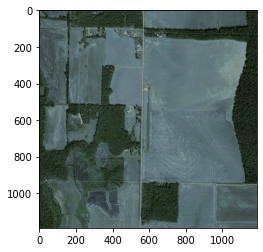

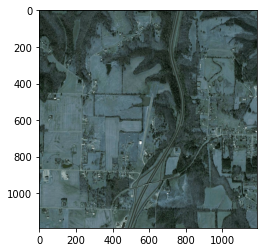

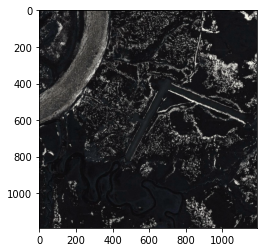

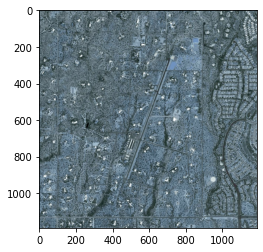

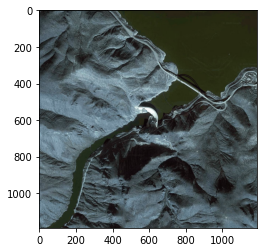

In [23]:
# View the misclassified images inline

import matplotlib.pyplot as plt

for img in misclassified_imgs:
  plt.figure()
  plt.imshow(cv2.imread('/content/mounted_drive/test/'+img))

Misclassified images are divided into two groups: Misclassified images containing airstrips and misclassified images not containing airstrips.

Each group is fed to a K-means clustering algorithm which assigns the images to one of four groups based on semantic similarity. 

The most representative image of each group is selected and used to search a dataset of thousands of airstrip/not-airstrip images for similar images. 

These new images are added to the training data and the model is retrained, learning to correctly classify the types of images it struggled with the first time around.

The model instance above is the result of several training + image gathering loops.

In [42]:
from keras.applications.resnet import ResNet50
from keras.models import Sequential
import numpy as np

# Load pretrained Resnet weights
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize a new model and add the pretrained Resnet layers on top of it
# Exclude the final layer of the resnet model so that outputs are not 'activated'
# The result will be the a vector embedding for the inputted image 
my_new_model = Sequential()
my_new_model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))

# Say not to train first layer (ResNet) model. It is already trained
my_new_model.layers[0].trainable = False

94773248/94765736 [==============================] - 2s 0us/step


In [0]:
import os
import glob
import cv2
from keras.applications.imagenet_utils import preprocess_input

# Get the Imagnet vector embeddings for all images in a directory
def extract_vectors(path):
    resnet_feature_list = []

    for im in glob.glob(path+'*.jpg'):
        
        im = cv2.imread(im)
        im = cv2.resize(im,(224,224))
        img = preprocess_input(np.expand_dims(im.copy(), axis=0))
        resnet_feature = my_new_model.predict(img)
        resnet_feature_np = np.array(resnet_feature)
        resnet_feature_list.append(resnet_feature_np.flatten())

    return np.array(resnet_feature_list)

# Get the Imagenet vector embeddings for a list of images
def extract_vectors_from_list(imgs):
    resnet_feature_list = []

    for im in imgs:
        
        im = cv2.imread(im)
        im = cv2.resize(im,(224,224))
        img = preprocess_input(np.expand_dims(im.copy(), axis=0))
        resnet_feature = my_new_model.predict(img)
        resnet_feature_np = np.array(resnet_feature)
        resnet_feature_list.append(resnet_feature_np.flatten())

    return np.array(resnet_feature_list)

# Get the Imagenet vector embedding for a single image
def extract_one_vector(path):
    resnet_feature_list = []

   
    im = cv2.imread(path)
    print(im.shape)
    im = cv2.resize(im,(224,224))
    img = preprocess_input(np.expand_dims(im.copy(), axis=0))
    resnet_feature = my_new_model.predict(img)
    resnet_feature_np = np.array(resnet_feature)
    resnet_feature_list.append(resnet_feature_np.flatten())

    return np.array(resnet_feature_list)

from sklearn.metrics.pairwise import cosine_similarity

# Find images that are semantically similar to a list of images
# Receives a list of images and their directory 
def get_similar_images(img_index, source):
    vector = extract_one_vector(img_index)
    cosine_similarities = []
    
    cos = cosine_similarity(vector, source)

    similar = np.argsort(-cos, axis=-1, kind='quicksort', order=None)[:,0:25] 

    return similar

# Display a list of images inline, given their indices and their directory
def show_images(index_array, directory):
  for index_list in index_array:
    for img_index in index_list:
      plt.figure()
      #print(directory+os.listdir(directory)[img_index])
      plt.imshow(cv2.imread(directory+os.listdir(directory)[img_index]))

# Return the paths of all images in a directory, given their indices
def get_paths(index_array, directory):
  img_paths = [ ]
  for index_list in index_array:
    for img_index in index_list:
      img_paths.append(directory+os.listdir(directory)[img_index])

  return img_paths

# Given a cluster, return all labels belonging to it
def cluster_indices(clust_num, labels_array): 
    return np.where(labels_array == clust_num)[0]

In [0]:
# Get vector representations of airstrip images
airstrip_vectors = extract_vectors('/content/mounted_drive/satellite_airstrips/extra_airstrips/')

# Get vector representations of satellite images that do not contain airstrips
not_airstrip_vectors = extract_vectors('/content/drive/My Drive/satellite_airstrips/index/')

In [0]:
import numpy as np

airstrip_vectors = np.load('/content/mounted_drive/airstrip_vectors.npy') # load
not_airstrip_vectors = np.load('/content/mounted_drive/not_airstrip_vectors.npy') # load

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
def similar_to_errors(error_image_directory, category):
  errors = extract_vectors_from_list(error_image_directory)
  kmeans = KMeans(n_clusters=4, random_state=0).fit(errors)
  print(kmeans.labels_)
  # for each cluster, get the most representative item (closest to centroid)
  if category == 'nstrips':
    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, nstrips_errors)
  else:
    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, strips_errors)

  
  cluster_0 = error_image_directory[closest[0]]
  cluster_1 = error_image_directory[closest[1]]
  cluster_2 = error_image_directory[closest[2]]
  cluster_3 = error_image_directory[closest[3]]

  clusters = [cluster_0, cluster_1, 
                    cluster_2, cluster_3]
  paths_list = []
  array_list = []
  for cluster in clusters:
    print(cluster)
    if category == 'nstrips':
      arrays = get_similar_images(cluster, not_airstrip_vectors)
      paths = get_paths(arrays, '/content/mounted_drive/satellite_airstrips/index/')
      array_list.append(arrays)
    else:
      arrays = get_similar_images(cluster, airstrip_vectors)
      paths = get_paths(arrays, '/content/mounted_drive/satellite_airstrips/extra_airstrips/')

    paths_list.append(paths)
    paths_list = [item for sublist in paths_list for item in sublist]

    return paths_list
    #return array_list
#clusters = similar_to_errors(misclassified_strips, 'strips')
#new_airstrip_paths = similar_to_errors(misclassified_strips, 'strips')
#new_n_airstrip_paths = similar_to_errors(nstrips_errors_dir, 'nstrips')

In [0]:
misclassified_strips = ['/content/mounted_drive/test/'+image for image in misclassified_imgs if image.startswith('strips')]
misclassified_not_strips = ['/content/mounted_drive/test/'+image for image in misclassified_imgs if image.startswith('not_strips')]

In [40]:
misclassified_strips

['/content/mounted_drive/test/strips/0A2DC496-F49E-426F-9709-E9C2AFE5345E.jpg',
 '/content/mounted_drive/test/strips/3CD1E697-7E62-40B0-8944-5B4D06183F75.jpg',
 '/content/mounted_drive/test/strips/5DFA7A4A-4449-4D28-AD94-3656445CCC66.jpg',
 '/content/mounted_drive/test/strips/AB9D6CBA-1B2A-4794-B959-46EA5D13BD38.jpg',
 '/content/mounted_drive/test/strips/AD75D47E-FD77-42D9-B2CE-CCECFBB4F12B.jpg',
 '/content/mounted_drive/test/strips/C0E1D327-86A0-4D6A-BC65-20B6816BFFDE.jpg']

In [0]:
strips_errors = extract_vectors_from_list(misclassified_strips)
nstrips_errors = extract_vectors_from_list(misclassified_not_strips)

In [61]:
new_airstrip_paths = similar_to_errors(misclassified_strips, 'strips')


[1 2 2 0 3 1]
/content/mounted_drive/test/strips/AB9D6CBA-1B2A-4794-B959-46EA5D13BD38.jpg
(1190, 1190, 3)


In [62]:
new_n_airstrip_paths = similar_to_errors(misclassified_not_strips, 'nstrips')

[2 1 0 0 1 3 1]
/content/mounted_drive/test/not_strips/42.1122281328539-90.40852258117864.jpg
(1190, 1190, 3)


In [63]:
new_airstrip_paths

['/content/mounted_drive/satellite_airstrips/extra_airstrips/408304D7-9DB8-44AC-B7B9-7D03C1196090.jpg',
 '/content/mounted_drive/satellite_airstrips/extra_airstrips/7FBE5507-7B11-4E94-A4DA-6739D05849FE.jpg',
 '/content/mounted_drive/satellite_airstrips/extra_airstrips/F3630E01-0FF7-44E1-A8B3-59B5E8A20255.jpg',
 '/content/mounted_drive/satellite_airstrips/extra_airstrips/5D7BB72C-AAC4-4EF2-9A1B-2464D802F03A.jpg',
 '/content/mounted_drive/satellite_airstrips/extra_airstrips/C5F98A6F-F3F0-4A2A-A595-283D22C8BC5E.jpg',
 '/content/mounted_drive/satellite_airstrips/extra_airstrips/41A6952C-4E6C-4D8A-A7BF-891CB04AFF20.jpg',
 '/content/mounted_drive/satellite_airstrips/extra_airstrips/A4D976C2-FCF3-499E-9619-350E0819A756.jpg',
 '/content/mounted_drive/satellite_airstrips/extra_airstrips/997ECF9C-CEFB-4827-B163-DA43F89CBCEC.jpg',
 '/content/mounted_drive/satellite_airstrips/extra_airstrips/083396E7-5E03-4670-949C-CE1F0103D68D.jpg',
 '/content/mounted_drive/satellite_airstrips/extra_airstrips/906

In [64]:
new_n_airstrip_paths

['/content/mounted_drive/satellite_airstrips/index/42.07523228787705-88.38734134736322.jpg',
 '/content/mounted_drive/satellite_airstrips/index/41.63065737447961-88.383043502444.jpg',
 '/content/mounted_drive/satellite_airstrips/index/41.723871410077805-88.06655658263718.jpg',
 '/content/mounted_drive/satellite_airstrips/index/42.03910253627225-88.02042061089631.jpg',
 '/content/mounted_drive/satellite_airstrips/index/35.21316662073188-106.56103775663688.jpg',
 '/content/mounted_drive/satellite_airstrips/index/34.97582047397454-106.68218951078774.jpg',
 '/content/mounted_drive/satellite_airstrips/index/42.046825219416746-88.39004508984142.jpg',
 '/content/mounted_drive/satellite_airstrips/index/41.74337019199648-88.06856252828712.jpg',
 '/content/mounted_drive/satellite_airstrips/index/34.95243349044121-106.36991958766734.jpg',
 '/content/mounted_drive/satellite_airstrips/index/34.99769691997887-106.67947889103463.jpg',
 '/content/mounted_drive/satellite_airstrips/index/42.085048971304